In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import lightgbm as lgb # For LightGBM Classifier
import joblib # For saving models
import os

# Set display options for better viewing of DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load the dataset
df = pd.read_csv('../data/adult.csv')

print("Dataset loaded successfully for preprocessing and modeling.")
print("Initial Shape:", df.shape)

Dataset loaded successfully for preprocessing and modeling.
Initial Shape: (48842, 15)


In [2]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Strip whitespace from all string values and replace '?' with NaN
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()
    df[col] = df[col].replace('?', np.nan)

print("Missing values after replacing '?' and stripping whitespace:")
print(df.isnull().sum())

Missing values after replacing '?' and stripping whitespace:
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


In [3]:
# Columns identified with '?' are typically 'workclass', 'occupation', 'native-country'
# Reconfirm these from your df.isnull().sum() output after the previous step
cols_to_impute_mode = ['workclass', 'occupation', 'native-country']

for col in cols_to_impute_mode:
    if df[col].isnull().any(): # Check if column actually has NaNs
        most_frequent_value = df[col].mode()[0]
        df[col] = df[col].fillna(most_frequent_value)
        print(f"Filled missing values in '{col}' with mode: '{most_frequent_value}'")

print("\nMissing values after imputation:")
print(df.isnull().sum())
print("DataFrame shape after imputation:", df.shape)

Filled missing values in 'workclass' with mode: 'Private'
Filled missing values in 'occupation' with mode: 'Prof-specialty'
Filled missing values in 'native-country' with mode: 'United-States'

Missing values after imputation:
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64
DataFrame shape after imputation: (48842, 15)


In [4]:
numerical_cols_for_outlier = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'educational-num']

print("\nApplying IQR-based outlier capping...")
for col in numerical_cols_for_outlier:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    # print(f"Outliers for '{col}' capped between {lower_bound:.2f} and {upper_bound:.2f}")

print("Outliers capped for numerical columns.")


Applying IQR-based outlier capping...
Outliers capped for numerical columns.


In [5]:
# 1. Interaction term: Education Level and Work Hours
# This might capture if highly educated people working long hours tend to earn more.
df['education_work_interaction'] = df['educational-num'] * df['hours-per-week']

# 2. Log transformation for highly skewed financial features
# This helps to reduce the impact of extreme values and make distributions more normal.
# Using np.log1p (log(1+x)) safely handles zero values.
df['capital-gain'] = np.log1p(df['capital-gain'])
df['capital-loss'] = np.log1p(df['capital-loss'])

# 3. Binary feature: Is Self-Employed?
df['is_self_employed'] = (df['workclass'].isin(['Self-emp-not-inc', 'Self-emp-inc'])).astype(int)

# 4. Binary feature: Is Married? (simplified marital status)
df['is_married'] = (df['marital-status'].isin(['Married-civ-spouse', 'Married-AF-spouse'])).astype(int)

print("\nNew features engineered:")
print(df[['education_work_interaction', 'capital-gain', 'capital-loss', 'is_self_employed', 'is_married']].head())


New features engineered:
   education_work_interaction  capital-gain  capital-loss  is_self_employed  is_married
0                       280.0           0.0           0.0                 0           0
1                       450.0           0.0           0.0                 0           1
2                       480.0           0.0           0.0                 0           1
3                       400.0           0.0           0.0                 0           1
4                       325.0           0.0           0.0                 0           0


In [6]:
# Cell 6: Encoding Categorical Features (One-Hot Encoding)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Identify categorical columns that need One-Hot Encoding
# Ensure these columns still exist after any previous transformations
ohe_cols = ['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'gender', 'native-country']

# Filter ohe_cols to only include columns that are present in df and are of 'object' dtype
ohe_cols = [col for col in ohe_cols if col in df.columns and df[col].dtype == 'object']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[ohe_cols])

# Create a DataFrame from encoded features, using the original DataFrame's index
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(ohe_cols), index=df.index)

# Drop original categorical columns from the main DataFrame
df = df.drop(columns=ohe_cols, axis=1, errors='ignore')

# Concatenate encoded features with the rest of the DataFrame
# Since both df and encoded_df now have the same index, concat should work correctly
df = pd.concat([df, encoded_df], axis=1)

# Encode the target variable 'income' using LabelEncoder
# '<=50K' will be 0, '>50K' will be 1 (alphabetical order by default)
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])

print("\nCategorical features One-Hot Encoded. Target Label Encoded.")
print("DataFrame shape after encoding:", df.shape)
print(df.head())


Categorical features One-Hot Encoded. Target Label Encoded.
DataFrame shape after encoding: (48842, 109)
    age    fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  income  education_work_interaction  is_self_employed  is_married  workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  education_10th  education_11th  education_12th  education_1st-4th  education_5th-6th  education_7th-8th  education_9th  education_Assoc-acdm  education_Assoc-voc  education_Bachelors  education_Doctorate  education_HS-grad  education_Masters  education_Preschool  education_Prof-school  education_Some-college  marital-status_Divorced  marital-status_Married-AF-spouse  marital-status_Married-civ-spouse  marital-status_Married-spouse-absent  marital-status_Never-married  marital-status_Separated  marital-status_Widowed  occupation_Adm-clerical  occupation_Armed-

In [7]:
# Identify all numerical columns for scaling (all columns except the target 'income')
features_to_scale = df.columns.drop('income').tolist()

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("\nNumerical features scaled using StandardScaler.")
print(df.head())


Numerical features scaled using StandardScaler.
        age    fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  income  education_work_interaction  is_self_employed  is_married  workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  education_10th  education_11th  education_12th  education_1st-4th  education_5th-6th  education_7th-8th  education_9th  education_Assoc-acdm  education_Assoc-voc  education_Bachelors  education_Doctorate  education_HS-grad  education_Masters  education_Preschool  education_Prof-school  education_Some-college  marital-status_Divorced  marital-status_Married-AF-spouse  marital-status_Married-civ-spouse  marital-status_Married-spouse-absent  marital-status_Never-married  marital-status_Separated  marital-status_Widowed  occupation_Adm-clerical  occupation_Armed-Forces  occupation_Craft-repair  occupation_Exec-mana

In [8]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('income', axis=1)
y = df['income']

# Split the data into training (80%) and testing (20%) sets
# stratify=y ensures that the proportion of income classes is the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape (X_train): {X_train.shape}, (y_train): {y_train.shape}")
print(f"Testing set shape (X_test): {X_test.shape}, (y_test): {y_test.shape}")


Training set shape (X_train): (39073, 108), (y_train): (39073,)
Testing set shape (X_test): (9769, 108), (y_test): (9769,)



--- Logistic Regression Model ---
Accuracy: 0.8398
F1 Score: 0.6246
Precision: 0.7111
Recall: 0.5569
ROC-AUC Score: 0.8843

Confusion Matrix:
 [[6902  529]
 [1036 1302]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      7431
           1       0.71      0.56      0.62      2338

    accuracy                           0.84      9769
   macro avg       0.79      0.74      0.76      9769
weighted avg       0.83      0.84      0.83      9769



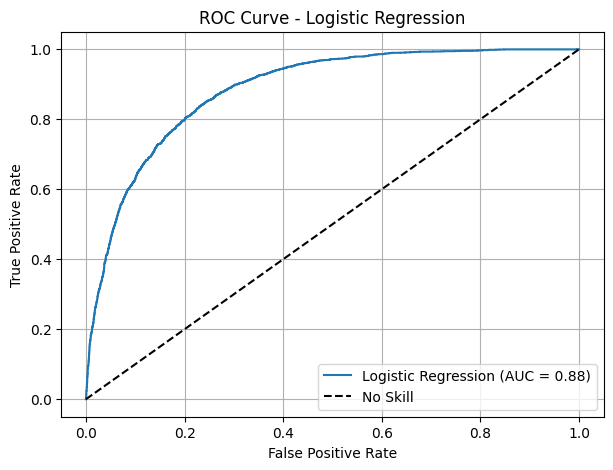

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt # Ensure matplotlib is imported

print("\n--- Logistic Regression Model ---")
# Initialize and train the Logistic Regression model
# solver='liblinear' is good for small datasets and handles L1/L2 regularization
# max_iter increased to ensure convergence for complex datasets
log_reg = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg.predict(X_test)
# Predict probabilities for ROC-AUC curve
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_log_reg):.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))

# Plot ROC Curve for Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
plt.figure(figsize=(7, 5))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log_reg):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill') # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid(True)
# Save the plot to the visualizations folder
if not os.path.exists('../visualizations'):
    os.makedirs('../visualizations')
plt.savefig('../visualizations/roc_curve_logistic_regression.png')
plt.show()


--- LightGBM Classifier Model ---


c:\Users\Balaji\OneDrive\Documents\employee_prediction_project\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Balaji\OneDrive\Documents\employee_prediction_project\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Balaji\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Balaji\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Balaji\AppData\Local\Progr

[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
Accuracy: 0.8450
F1 Score: 0.6489
Precision: 0.7087
Recall: 0.5984
ROC-AUC Score: 0.8954

Confusion Matrix:
 [[6856  575]
 [ 939 1399]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      7431
           1       0.71      0.60      0.65      2338

    accuracy                           0.85      9769
   macro avg       0.79      0.76      0.77      9769
weighted av

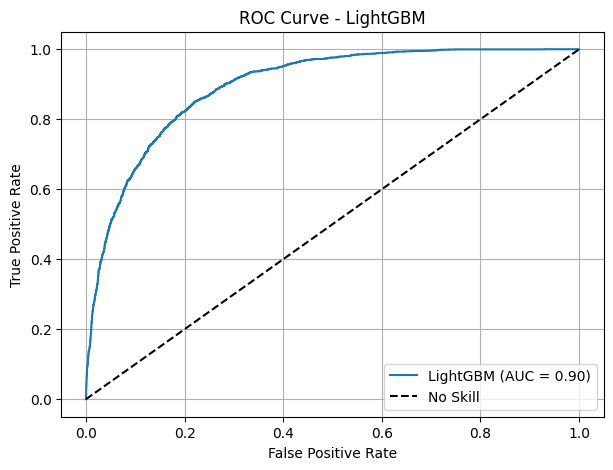

In [10]:
import lightgbm as lgb # Ensure lightgbm is imported

print("\n--- LightGBM Classifier Model ---")
# Initialize and train the LightGBM model
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgbm = lgbm.predict(X_test)
# Predict probabilities for ROC-AUC curve
y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_lgbm):.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

# Plot ROC Curve for LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
plt.figure(figsize=(7, 5))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_prob_lgbm):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.grid(True)
plt.savefig('../visualizations/roc_curve_lightgbm.png')
plt.show()


--- LightGBM Model with Fixed Parameters (No Hyperparameter Tuning) ---
[LightGBM] [Info] Number of positive: 9349, number of negative: 29724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 39073, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239270 -> initscore=-1.156685
[LightGBM] [Info] Start training from score -1.156685
Accuracy: 0.8449
F1 Score: 0.6468
Precision: 0.7109
Recall: 0.5932
ROC-AUC Score: 0.8956

Confusion Matrix:
 [[6867  564]
 [ 951 1387]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      7431
           1       0.71      0.59      0.65      2338

    accuracy                           0.84   

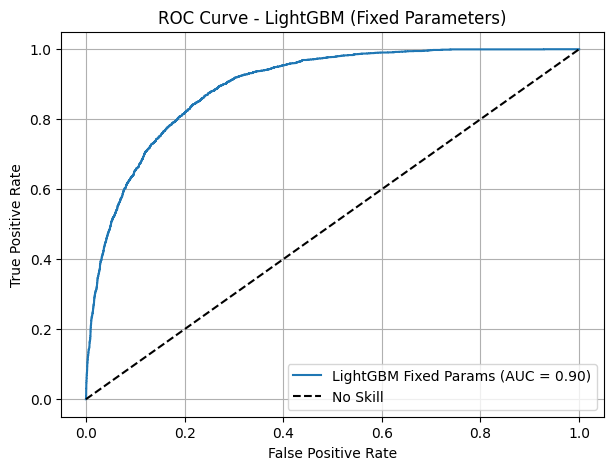

In [11]:
# Cell 11: Train LightGBM with Fixed Parameters (No Tuning - for faster execution)
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os # Make sure os is imported for saving plots

print("\n--- LightGBM Model with Fixed Parameters (No Hyperparameter Tuning) ---")

# Initialize and train the LightGBM model with default or pre-chosen reasonable parameters
# These parameters are often a good starting point and provide decent performance.
lgbm_fixed = lgb.LGBMClassifier(
    n_estimators=200,      # Number of boosting rounds
    learning_rate=0.05,    # Step size shrinkage
    num_leaves=31,         # Max number of leaves in one tree
    max_depth=-1,          # No limit on tree depth (can be adjusted to 5-7 for smaller models)
    random_state=42        # For reproducibility
)
lgbm_fixed.fit(X_train, y_train)

# Make predictions on the test set
y_pred_fixed_lgbm = lgbm_fixed.predict(X_test)
# Predict probabilities for ROC-AUC curve
y_prob_fixed_lgbm = lgbm_fixed.predict_proba(X_test)[:, 1]

# Set the 'best_lgbm_model' to this fixed model so Cell 12 can save it
best_lgbm_model = lgbm_fixed

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_fixed_lgbm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_fixed_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_fixed_lgbm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_fixed_lgbm):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_fixed_lgbm):.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_fixed_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_fixed_lgbm))

# Plot ROC Curve for LightGBM with Fixed Parameters
fpr_fixed_lgbm, tpr_fixed_lgbm, _ = roc_curve(y_test, y_prob_fixed_lgbm)
plt.figure(figsize=(7, 5))
plt.plot(fpr_fixed_lgbm, tpr_fixed_lgbm, label=f'LightGBM Fixed Params (AUC = {roc_auc_score(y_test, y_prob_fixed_lgbm):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM (Fixed Parameters)')
plt.legend()
plt.grid(True)
# Ensure the directory exists before saving
if not os.path.exists('../visualizations'):
    os.makedirs('../visualizations')
plt.savefig('../visualizations/roc_curve_lightgbm_fixed_params.png')
plt.show()

In [13]:
# Cell 12: Model and Transformer Saving (UPDATED)
import joblib
import os

# Create the models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best performing model (e.g., the tuned/fixed LightGBM model)
joblib.dump(best_lgbm_model, '../models/best_lightgbm_model.pkl')
print("Best LightGBM model saved to ../models/best_lightgbm_model.pkl")

# --- NEW: Save the fitted StandardScaler and OneHotEncoder ---
# Assuming 'scaler' and 'encoder' variables are still in memory from Cell 7 and Cell 6 respectively.
# If you restarted your kernel, you will need to run all cells from the beginning (Cell 1-10) before running this.
joblib.dump(scaler, '../models/scaler.pkl')
print("Fitted StandardScaler saved to ../models/scaler.pkl")

joblib.dump(encoder, '../models/encoder.pkl')
print("Fitted OneHotEncoder saved to ../models/encoder.pkl")

print("\nAll necessary model components saved.")

Best LightGBM model saved to ../models/best_lightgbm_model.pkl
Fitted StandardScaler saved to ../models/scaler.pkl
Fitted OneHotEncoder saved to ../models/encoder.pkl

All necessary model components saved.


In [ ]:
# Cell 13: Making Predictions on Sample Input
import pandas as pd
import numpy as np
import joblib
import os # Ensure os is imported if not already

# --- 1. Load the Saved Model and Transformers ---
try:
    loaded_model = joblib.load('../models/best_lightgbm_model.pkl')
    loaded_scaler = joblib.load('../models/scaler.pkl')
    loaded_encoder = joblib.load('../models/encoder.pkl')
    print("Model, scaler, and encoder loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure 'best_lightgbm_model.pkl', 'scaler.pkl', and 'encoder.pkl' exist in the '../models/' directory.")
    print("Please ensure you ran the updated Cell 12 (Model and Transformer Saving).")
    exit() # Exit or handle gracefully if files are not found

# --- 2. Define a Sample Input ---
# This dictionary represents a new individual for whom you want to predict income.
# IMPORTANT: All columns and their data types must match your original raw data columns!
sample_input = {
    'age': 35,
    'workclass': 'Private',
    'fnlwgt': 200000,
    'education': 'Bachelors',
    'educational-num': 13, # Equivalent to Bachelors
    'marital-status': 'Married-civ-spouse',
    'occupation': 'Exec-managerial',
    'relationship': 'Husband',
    'race': 'White',
    'gender': 'Male',
    'capital-gain': 2000,
    'capital-loss': 0,
    'hours-per-week': 45,
    'native-country': 'United-States'
}

# Create a DataFrame from the sample input
sample_df = pd.DataFrame([sample_input])

print("\nSample Input Data:")
print(sample_df)

# --- 3. Apply the Same Preprocessing Steps to the Sample Input ---

# 3.1. Strip whitespace and handle '?' (if applicable, though sample is usually clean)
for col in sample_df.select_dtypes(include='object').columns:
    sample_df[col] = sample_df[col].astype(str).str.strip() # Ensure it's string type for .str accessor
    sample_df[col] = sample_df[col].replace('?', np.nan) # Replace '?' with NaN if any


cols_to_impute_mode = ['workclass', 'occupation', 'native-country']


# 3.3. Feature Engineering (must match the training pipeline)
sample_df['education_work_interaction'] = sample_df['educational-num'] * sample_df['hours-per-week']
sample_df['capital-gain'] = np.log1p(sample_df['capital-gain'])
sample_df['capital-loss'] = np.log1p(sample_df['capital-loss'])
sample_df['is_self_employed'] = (sample_df['workclass'].isin(['Self-emp-not-inc', 'Self-emp-inc'])).astype(int)
sample_df['is_married'] = (sample_df['marital-status'].isin(['Married-civ-spouse', 'Married-AF-spouse'])).astype(int)


# 3.4. One-Hot Encode Categorical Features (using the LOADED encoder)
ohe_cols = ['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'gender', 'native-country']

# Filter ohe_cols to only include columns that are present in sample_df and are of 'object' dtype
ohe_cols = [col for col in ohe_cols if col in sample_df.columns and sample_df[col].dtype == 'object']

# Transform the sample data using the loaded encoder
# Use .transform, not .fit_transform!
encoded_sample_features = loaded_encoder.transform(sample_df[ohe_cols])
encoded_sample_df = pd.DataFrame(encoded_sample_features, columns=loaded_encoder.get_feature_names_out(ohe_cols), index=sample_df.index)

# Drop original categorical columns from sample_df
sample_df_processed = sample_df.drop(columns=ohe_cols, axis=1, errors='ignore')

# Concatenate encoded features with the rest of the sample DataFrame
sample_df_processed = pd.concat([sample_df_processed, encoded_sample_df], axis=1)


try:
    if 'X_train' in locals(): # Check if X_train is defined in the current scope
        feature_columns_order = X_train.columns.tolist()
    else: 
        print("Warning: X_train not found in memory. Relying on implicit column order for scaling, which can be fragile.")
        
        raise NameError("X_train not found. Please ensure you've run cells up to data splitting before this cell.")

    # Reindex sample_df_processed to match the exact column order of X_train
    # This is crucial for correct prediction
    sample_df_processed = sample_df_processed.reindex(columns=feature_columns_order, fill_value=0)


except NameError as e:
    print(f"Error: {e}")
    print("Please ensure you've run all cells from the beginning of `salary_prediction_modeling.ipynb` up to Cell 8 (Data Splitting) before running this prediction cell.")
    exit()


# 3.5. Scale Numerical Features (using the LOADED scaler)
# Use .transform, not .fit_transform!
scaled_sample_features = loaded_scaler.transform(sample_df_processed)
final_sample_input = pd.DataFrame(scaled_sample_features, columns=sample_df_processed.columns)


print("\nProcessed and Scaled Sample Input for Prediction:")
print(final_sample_input)

# --- 4. Make Prediction ---
prediction_numeric = loaded_model.predict(final_sample_input)
prediction_proba = loaded_model.predict_proba(final_sample_input)[:, 1] # Probability of ">50K"

# --- 5. Interpret the Prediction ---
# Remember, in LabelEncoder, <=50K was mapped to 0 and >50K was mapped to 1.
income_map = {0: '<=50K', 1: '>50K'}
predicted_income = income_map[prediction_numeric[0]]

print(f"\nPredicted Income: {predicted_income}")
print(f"Probability of earning >50K: {prediction_proba[0]:.4f}")

if predicted_income == '>50K':
    print("\nBased on the input, the model predicts this individual likely earns more than $50K annually.")
else:
    print("\nBased on the input, the model predicts this individual likely earns $50K or less annually.")

Model, scaler, and encoder loaded successfully!

Sample Input Data:
   age workclass  fnlwgt  education  educational-num      marital-status       occupation relationship   race gender  capital-gain  capital-loss  hours-per-week native-country
0   35   Private  200000  Bachelors               13  Married-civ-spouse  Exec-managerial      Husband  White   Male          2000             0              45  United-States

Processed and Scaled Sample Input for Prediction:
        age    fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week  education_work_interaction  is_self_employed  is_married  workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  workclass_Without-pay  education_10th  education_11th  education_12th  education_1st-4th  education_5th-6th  education_7th-8th  education_9th  education_Assoc-acdm  education_Assoc-voc  education_Bachelors  education_Doctorate 